# Homework 2


Instructions: Click **Copy to drive** at the menu bar, and enter your solutions.

Submission: Please upload your completed **solution .ipynb file** to [Brightspace](https://it.stonybrook.edu/services/brightspace) by **March 23, 11:59PM EST**.

In [ ]:
# install required package
!pip3 install nibabel
!pip3 install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 16.4 MB/s eta 0:00:00


In [ ]:
# Setting up various plot functions to be used throughout the notebook

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import nibabel as nib
import os
import SimpleITK as sitk

# plot one or a list of images
def plot_images(images, title=None, figsize=(15,15)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        axes[image_id].imshow(image, cmap='gray')
        axes[image_id].axis('off')
        if not title:
            axes[image_id].set_title('Image {}'.format(image_id), fontsize=20)
        elif len(title) == 1:
            axes[image_id].set_title('Image {}: {}'.format(image_id, title[0]), fontsize=20)
        else:
            axes[image_id].set_title('Image {}: {}'.format(image_id, title[image_id]), fontsize=20)
    f.tight_layout()


def plot_grids(grids, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array, axis=0),
               interpolation='hamming',
               cmap='gray',
               origin='lower')
        axes[grid_id].axis('off')
        axes[grid_id].set_title('Grid {}'.format(grid_id), fontsize=20)
    f.tight_layout()


def plot_grids_and_images(grids, images, figsize=(15,15)):
    f, axes = plt.subplots(1, len(grids), figsize=figsize)
    for grid_id, grid in enumerate(grids):
        grid_array = sitk.GetArrayViewFromImage(grid)
        axes[grid_id].imshow(np.flip(grid_array/np.max(grid_array)*images[grid_id]/np.max(images[grid_id]), axis=0),
               interpolation=None,
               cmap='gray',
               origin='lower')
        axes[grid_id].axis('off')
        axes[grid_id].set_title('Grid overlay {}'.format(grid_id), fontsize=20)
    f.tight_layout()

# function used to plot histograms
def plot_histograms(images, figsize=(15,7.5)):
    f, axes = plt.subplots(1, len(images), figsize=figsize)
    for image_id, image in enumerate(images):
        histogram, bins = np.histogram(image, bins=40)
        axes[image_id].set_xlim([0, 120])
        axes[image_id].hist(histogram, bins)
        axes[image_id].set_title('Image {} Histogram'.format(image_id), fontsize=20)
    f.tight_layout()

# Exercise 1. Histogram Normalisation (30 points)
Histogram normalisation is the process of standardising contrasts across an imaging dataset. We do this to limit the capacity of the network spent to model contrast differences across images in tasks such as segmentation, registration, and volumetric measurements. We will go through the step by step process of histogram normalisation on a hippocampus dataset.
  
While histogram normalisation can be done on a case-by-case basis, given a dataset spanning a number of subjects we would like to normalise them all to a common intensity profile. This can be accomplished according to the details in [this](https://ieeexplore.ieee.org/iel5/42/18064/00836373.pdf) paper, the main details of which we'll cover here.  

The process is as follows:

1. A range of percentiles for standardisation are chosen, e.g.: 10, 20, 30, 40, ..., 90
2. Calculate value of percentiles (i.e.: landmarks) for each of the "train" images
3. Calculate a linear mapping between the intensities of the [min, max] percentiles and the limits of the new "standard" scale (e.g.: [0, 100]).
4. Apply this mapping to each landmark
5. Average the mapped landmarks across all the train images to obtain an average mapping
6. Apply this mapping on any new images (Of the same modality!)

You will want to read how these two functions work to complete the exercise (**Hint**: When calling interp1d you will want to set the fill_value flag to 'extrapolate'):
1. [np.percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)
2. [interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

This should be implemented using default linear interpolation, which implements the following mapping between the original intensities, $x$, and a new intensity space $x'$:

<center> $x' = s_1 + \frac{x - p_{1}}{p_2-p_1}(s_2 - s_1)$ </center>

Here, [$s_1, s_2$] are the min and max intensities of the new scale and [$p_1, p_2$] are the min and max landmarks for the original image.

Let's first begin by just loading in the dataset:

In [ ]:
# Download images
file_download_link = "https://github.com/charlesyou999648/MedIA/raw/main/img/Homework2_Hippocampus.tar"
!wget -O Homework2_Hippocampus.tar --no-check-certificate "$file_download_link"
!tar -xf Homework2_Hippocampus.tar

--2025-03-24 01:09:24--  https://github.com/charlesyou999648/MedIA/raw/main/img/Homework2_Hippocampus.tar
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/charlesyou999648/MedIA/main/img/Homework2_Hippocampus.tar [following]
--2025-03-24 01:09:24--  https://raw.githubusercontent.com/charlesyou999648/MedIA/main/img/Homework2_Hippocampus.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19384320 (18M) [application/octet-stream]
Saving to: ‘Homework2_Hippocampus.tar’

Homework2_Hippocamp 100%[===================>]  18.49M   113MB/s    in 0.2s    

2025-03-24 01:09:24 (113 MB/s) - ‘Homework2_Hippoc

In [ ]:
def read_file(filename):
    img = nib.load(filename)
    data = img.get_fdata()
    aff = img.affine
    return data, aff

# Build the 2D dataset: Let's take 20 images
dataset = []
data_dir = 'Homework2_Hippocampus/imagesTr'
images = os.listdir(data_dir)
for entry in range(20):
    image, _ = read_file(data_dir + '/' + images[entry])
    # Let's take the middle slice and normalise
    dataset.append(100 * image[:, :, 17] / np.max(image[:, :, 17]))

You may begin coding the training function in the cell below:

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def calc_landmarks_from_percentiles(image, percentile_list):
    landmarks = np.percentile(image, percentile_list)
    return landmarks

def create_trained_mapping(images, percentile_list, scale_min, scale_max, p_min, p_max):
    average_mapped_landmarks = np.zeros(len(percentile_list),)
    for image in images:
        # 1.2. Calculate the landmarks for each image
        landmarks = calc_landmarks_from_percentiles(image, percentile_list)
        # 1.3.  Calculate the image intensities corresponding to your chosen minimum and maximum percentiles
        intensity_min = np.percentile(image, p_min)
        intensity_max = np.percentile(image, p_max)
        # 1.4. Create mapping by interpolating between the image's min + max values and those of the standard scale
        mapping = interp1d([intensity_min, intensity_max], [scale_min, scale_max], fill_value='extrapolate')
        # 1.5. Map the image landmarks to these values
        mapped_landmarks = mapping(landmarks)
        # Sum the mapped landmarks iteratively
        average_mapped_landmarks += mapped_landmarks
    # Average the summed landmarks
    average_mapped_landmarks = average_mapped_landmarks / len(images)
    return average_mapped_landmarks

Now that we've coded the mapping training function I'd like you to code a function that applies the learned mapping to a new image, and test the method:

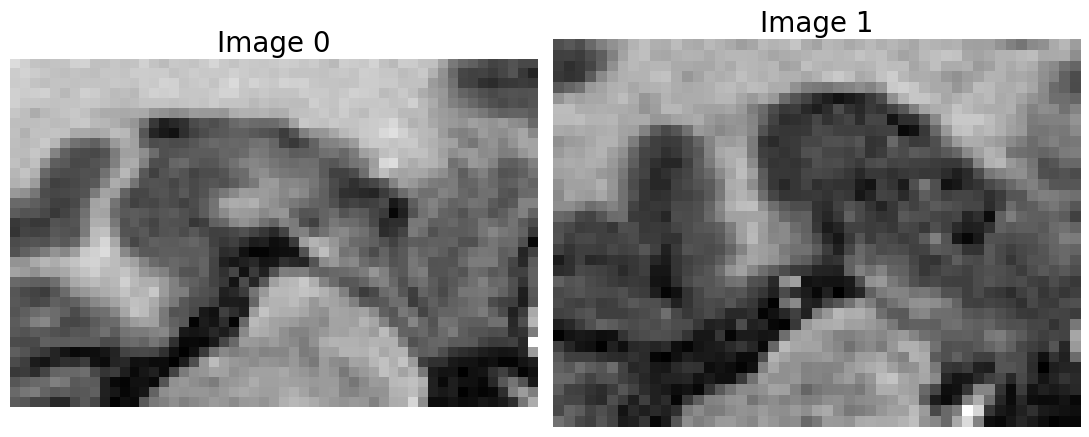

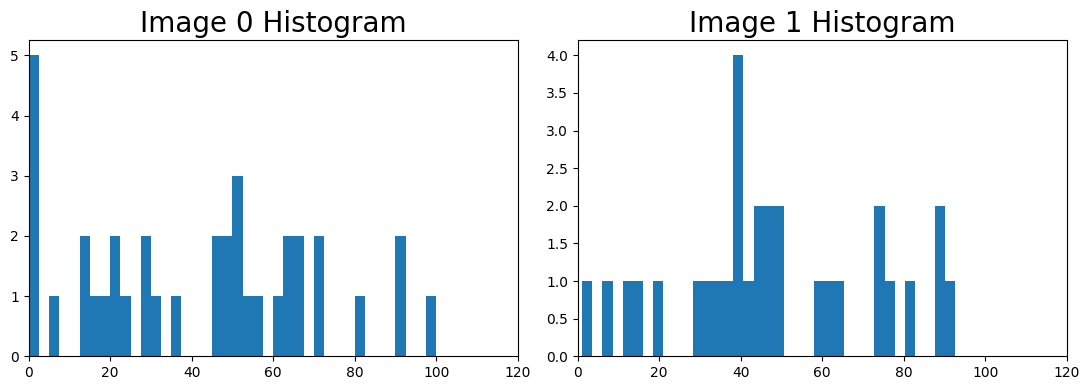

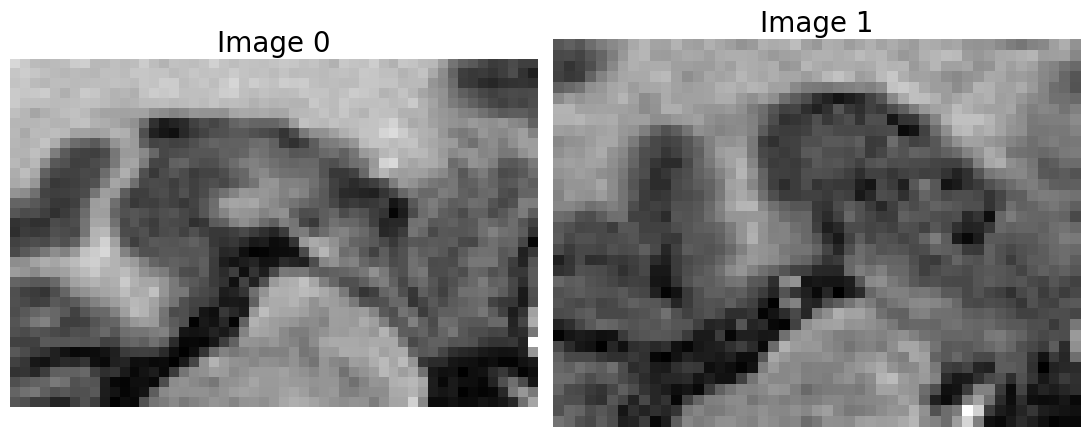

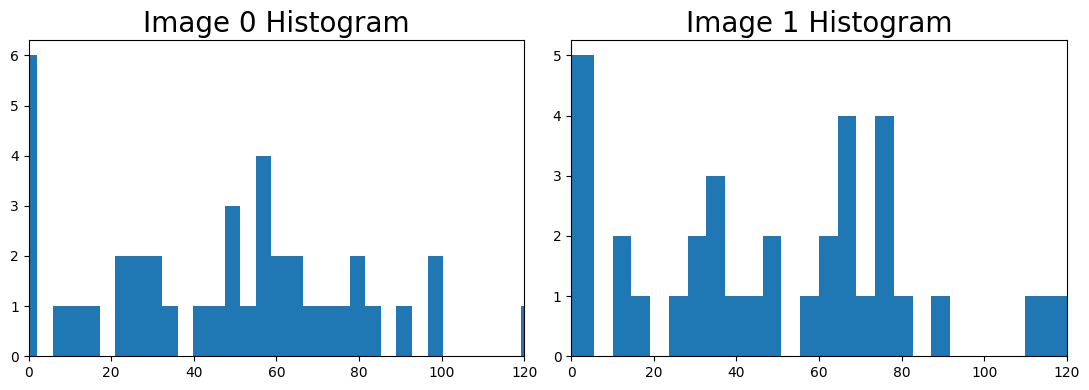

In [ ]:
# 1.6. Code function to apply mapped landmarks to a new image
def standardise_image(image, percentile_list, average_mapped_landmarks):
    # Calculate the landmarks for the image
    landmarks = calc_landmarks_from_percentiles(image, percentile_list)
    # Calculate mapping between the landmarks of this image and the averaged mapped landmarks
    mapping = interp1d(landmarks, average_mapped_landmarks, fill_value='extrapolate')
    # Apply this mapping  to the new image
    new_image = mapping(image)
    return new_image


# Test the method
percentile_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
trained_mapping = create_trained_mapping(images=dataset[3:],
                                         percentile_list = percentile_list,
                                         scale_min=0, scale_max=100,
                                         p_min=5, p_max=95)

normalised_images = []
for image in dataset[14:16]:
    normalised_images.append(standardise_image(image, percentile_list, trained_mapping))

# Before
plot_images(dataset[14:16], figsize=(11, 11))
plot_histograms(dataset[14:16], figsize=(11, 4))

# After
plot_images(normalised_images, figsize=(11, 11))
plot_histograms(normalised_images, figsize=(11, 4))

# Exercise 2. Bias field correction (15 points)


MRI images will sometimes exhibit a form of corruption termed *bias* or *intensity inhomogeneities*. They arise as a result of imperfections in the imaging pipeline, and cause low-frequency intensity changes across the image as shown in the figure below:
<br>
<div>
<center>
  <img src="https://raw.githubusercontent.com/charlesyou999648/MedIA/master/img/BiasFieldImage.png" width="750"/>
</center>
</div>

> __Figure__: Coronal brain slice corrupted by a bias field (Left). Corresponding bias field map (Right).  
>[A review of methods for correction of intensity inhomogeneity in MRI.](https://www.ncbi.nlm.nih.gov/pubmed/17354645)  


### Load Image
Download the sample image [here](https://drive.google.com/file/d/1eXP0jRNQJxEgbR17aPimAe-S15mGnoZP/view?usp=sharing).

In [ ]:
import SimpleITK as sitk

In [ ]:
raw_img_path = '/content/drive/MyDrive/Medical Image Analysis/img_hw2_q2.nii.gz'
raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)
raw_img_sitk = sitk.DICOMOrient(raw_img_sitk,'RPS')

raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)

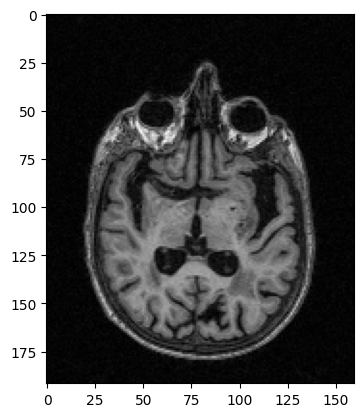

In [ ]:
plt.imshow(raw_img_sitk_arr[96], cmap='gray')
plt.show()

### Create head mask

In order to perform correction on the brain region only, we use thresholding method to get the brain mask. Complete the code below to use Otsu thresholding method to get the brain mask. SimpleITK already provides the Otsu thresholding function.

Read more about Otsu thresholding [here](https://en.wikipedia.org/wiki/Otsu%27s_method).

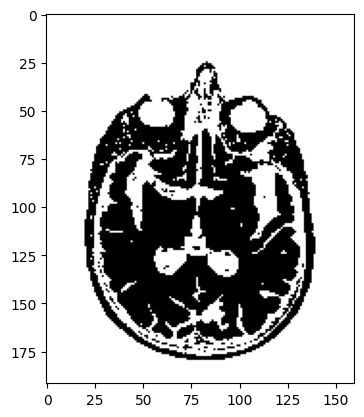

In [ ]:
transformed_img = sitk.RescaleIntensity(raw_img_sitk, 0, 255)

# YOUR CODE HERE
head_mask = sitk.OtsuThreshold(transformed_img)

head_mask_npy = sitk.GetArrayFromImage(head_mask)

plt.imshow(head_mask_npy[96], cmap='gray')
plt.show()

### Bias Correction
Since bias correction can be time consuming, we typically shrink the image to reduce the size. Complete the code below to use SimpleITK to shrink the image by a factor of 4.

**Hint:** Use the sitk.Shrink function.

In [ ]:
shrinkFactor = 4
inputImage = raw_img_sitk

print('Before:', raw_img_sitk.GetSize())
# YOUR CODE HERE
inputImage = sitk.Shrink(raw_img_sitk, [shrinkFactor] * raw_img_sitk.GetDimension())
inputMask = sitk.Shrink(head_mask, [shrinkFactor] * head_mask.GetDimension())
print('After:', inputImage.GetSize())

Before: (160, 192, 192)
After: (40, 48, 48)


In [ ]:
bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()

corrected = bias_corrector.Execute(inputImage, inputMask)

### Inspect the bias field

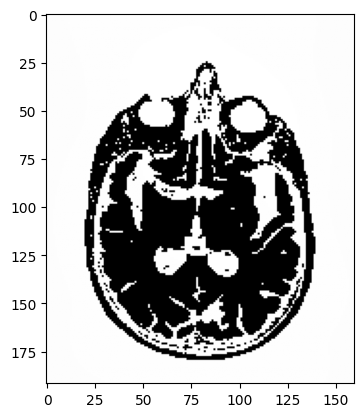

In [ ]:
log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img_sitk)
bias_field = sitk.Exp(log_bias_field)
bias_field = sitk.Mask(bias_field, head_mask)

bias_field_arr = sitk.GetArrayFromImage(bias_field)

plt.imshow(bias_field_arr[96], cmap='gray')
plt.show()

### Get corrected image

Since you have obtained the log bias field, now please finish the last step by apply it to the input raw image by: input/exp(log_bias_field).

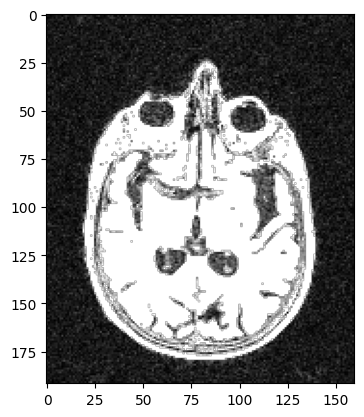

In [ ]:
# YOUR CODE HERE
corrected_full_res = raw_img_sitk / bias_field
corrected_full_res_arr = sitk.GetArrayFromImage(corrected_full_res)

plt.imshow(corrected_full_res_arr[96], cmap='gray')
plt.show()

# Exercise 3. Image Resampling (15 points)
**Background:** Image resampling is a process of changing the pixel or voxel size of an image without altering its spatial extent in the patient coordinate system. It is often used to standardize the image resolution across a data set that contains images from different scanners or modalities. It can also help to align images from different sources, extract regions of interest.

**Task:** Download the image [here](https://drive.google.com/file/d/1ygVLPQgp_bopWs-SDWSjxtrHD74cdMBS/view?usp=sharing) and the mask [here](https://drive.google.com/file/d/1LqPO31Xya6cNPYMxNyUVMMoEGXjRKmaD/view?usp=sharing).
1. Complete the code below to use SimpleITK to resample the image to to 1mm isotropic.

In [ ]:
img = sitk.ReadImage('/content/drive/MyDrive/Medical Image Analysis/img_hw2_q3_19676E.nii.gz')
mask = sitk.ReadImage('/content/drive/MyDrive/Medical Image Analysis/mask_hw2_q3_19676E.nii.gz')

In [ ]:
def convert_to_isotropic(inputVolume, isoSpacing=1.0):

    inputSpacing = inputVolume.GetSpacing()
    inputSize = inputVolume.GetSize()
    inputDirection = inputVolume.GetDirection()
    inputOrigin = inputVolume.GetOrigin()
    outputSpacing = [isoSpacing, isoSpacing, isoSpacing]
    outputSize = [
        int(np.round(inputSize[0] * inputSpacing[0] / isoSpacing)),
        int(np.round(inputSize[1] * inputSpacing[1] / isoSpacing)),
        int(np.round(inputSize[2] * inputSpacing[2] / isoSpacing))
    ]

    # Set up the resampling filter
    resampleFilter = sitk.ResampleImageFilter()
    resampleFilter.SetOutputSpacing(outputSpacing)
    resampleFilter.SetOutputOrigin(inputOrigin)
    resampleFilter.SetOutputDirection(inputDirection)
    resampleFilter.SetSize(outputSize)
    resampleFilter.SetInterpolator(sitk.sitkLinear)  # Linear interpolation
    resampleFilter.SetDefaultPixelValue(0)

    resampleVolume = resampleFilter.Execute(inputVolume)

    return resampleVolume

In [ ]:
img_converted = convert_to_isotropic(img, isoSpacing=1.0)

2. Set the origin coordinates of the image to be the same as the mask.

In [ ]:
def resample_mask_to_match(mask, reference_image):
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference_image)
    resample.SetInterpolator(sitk.sitkNearestNeighbor)  # Use nearest neighbor for masks
    resampled_mask = resample.Execute(mask)
    return resampled_mask

# Resample the mask to match the dimensions of the resampled image
mask_resampled = resample_mask_to_match(mask, img_converted)

# Save the files for visualization in ITK-SNAP
sitk.WriteImage(img_converted, "resampled_image.nii.gz")
sitk.WriteImage(mask_resampled, "resampled_mask.nii.gz")

# Print dimensions to verify they match
print("Resampled image dimensions:", img_converted.GetSize())
print("Resampled mask dimensions:", mask_resampled.GetSize())

Resampled image dimensions: (387, 387, 320)
Resampled mask dimensions: (387, 387, 320)


3. If you have done the resampling correctly, you should be able to overlay the segmentation mask on top of the image using ITK-SNAP. Attach a screen shot of overlayed segmentation on ITK-SNAP below.

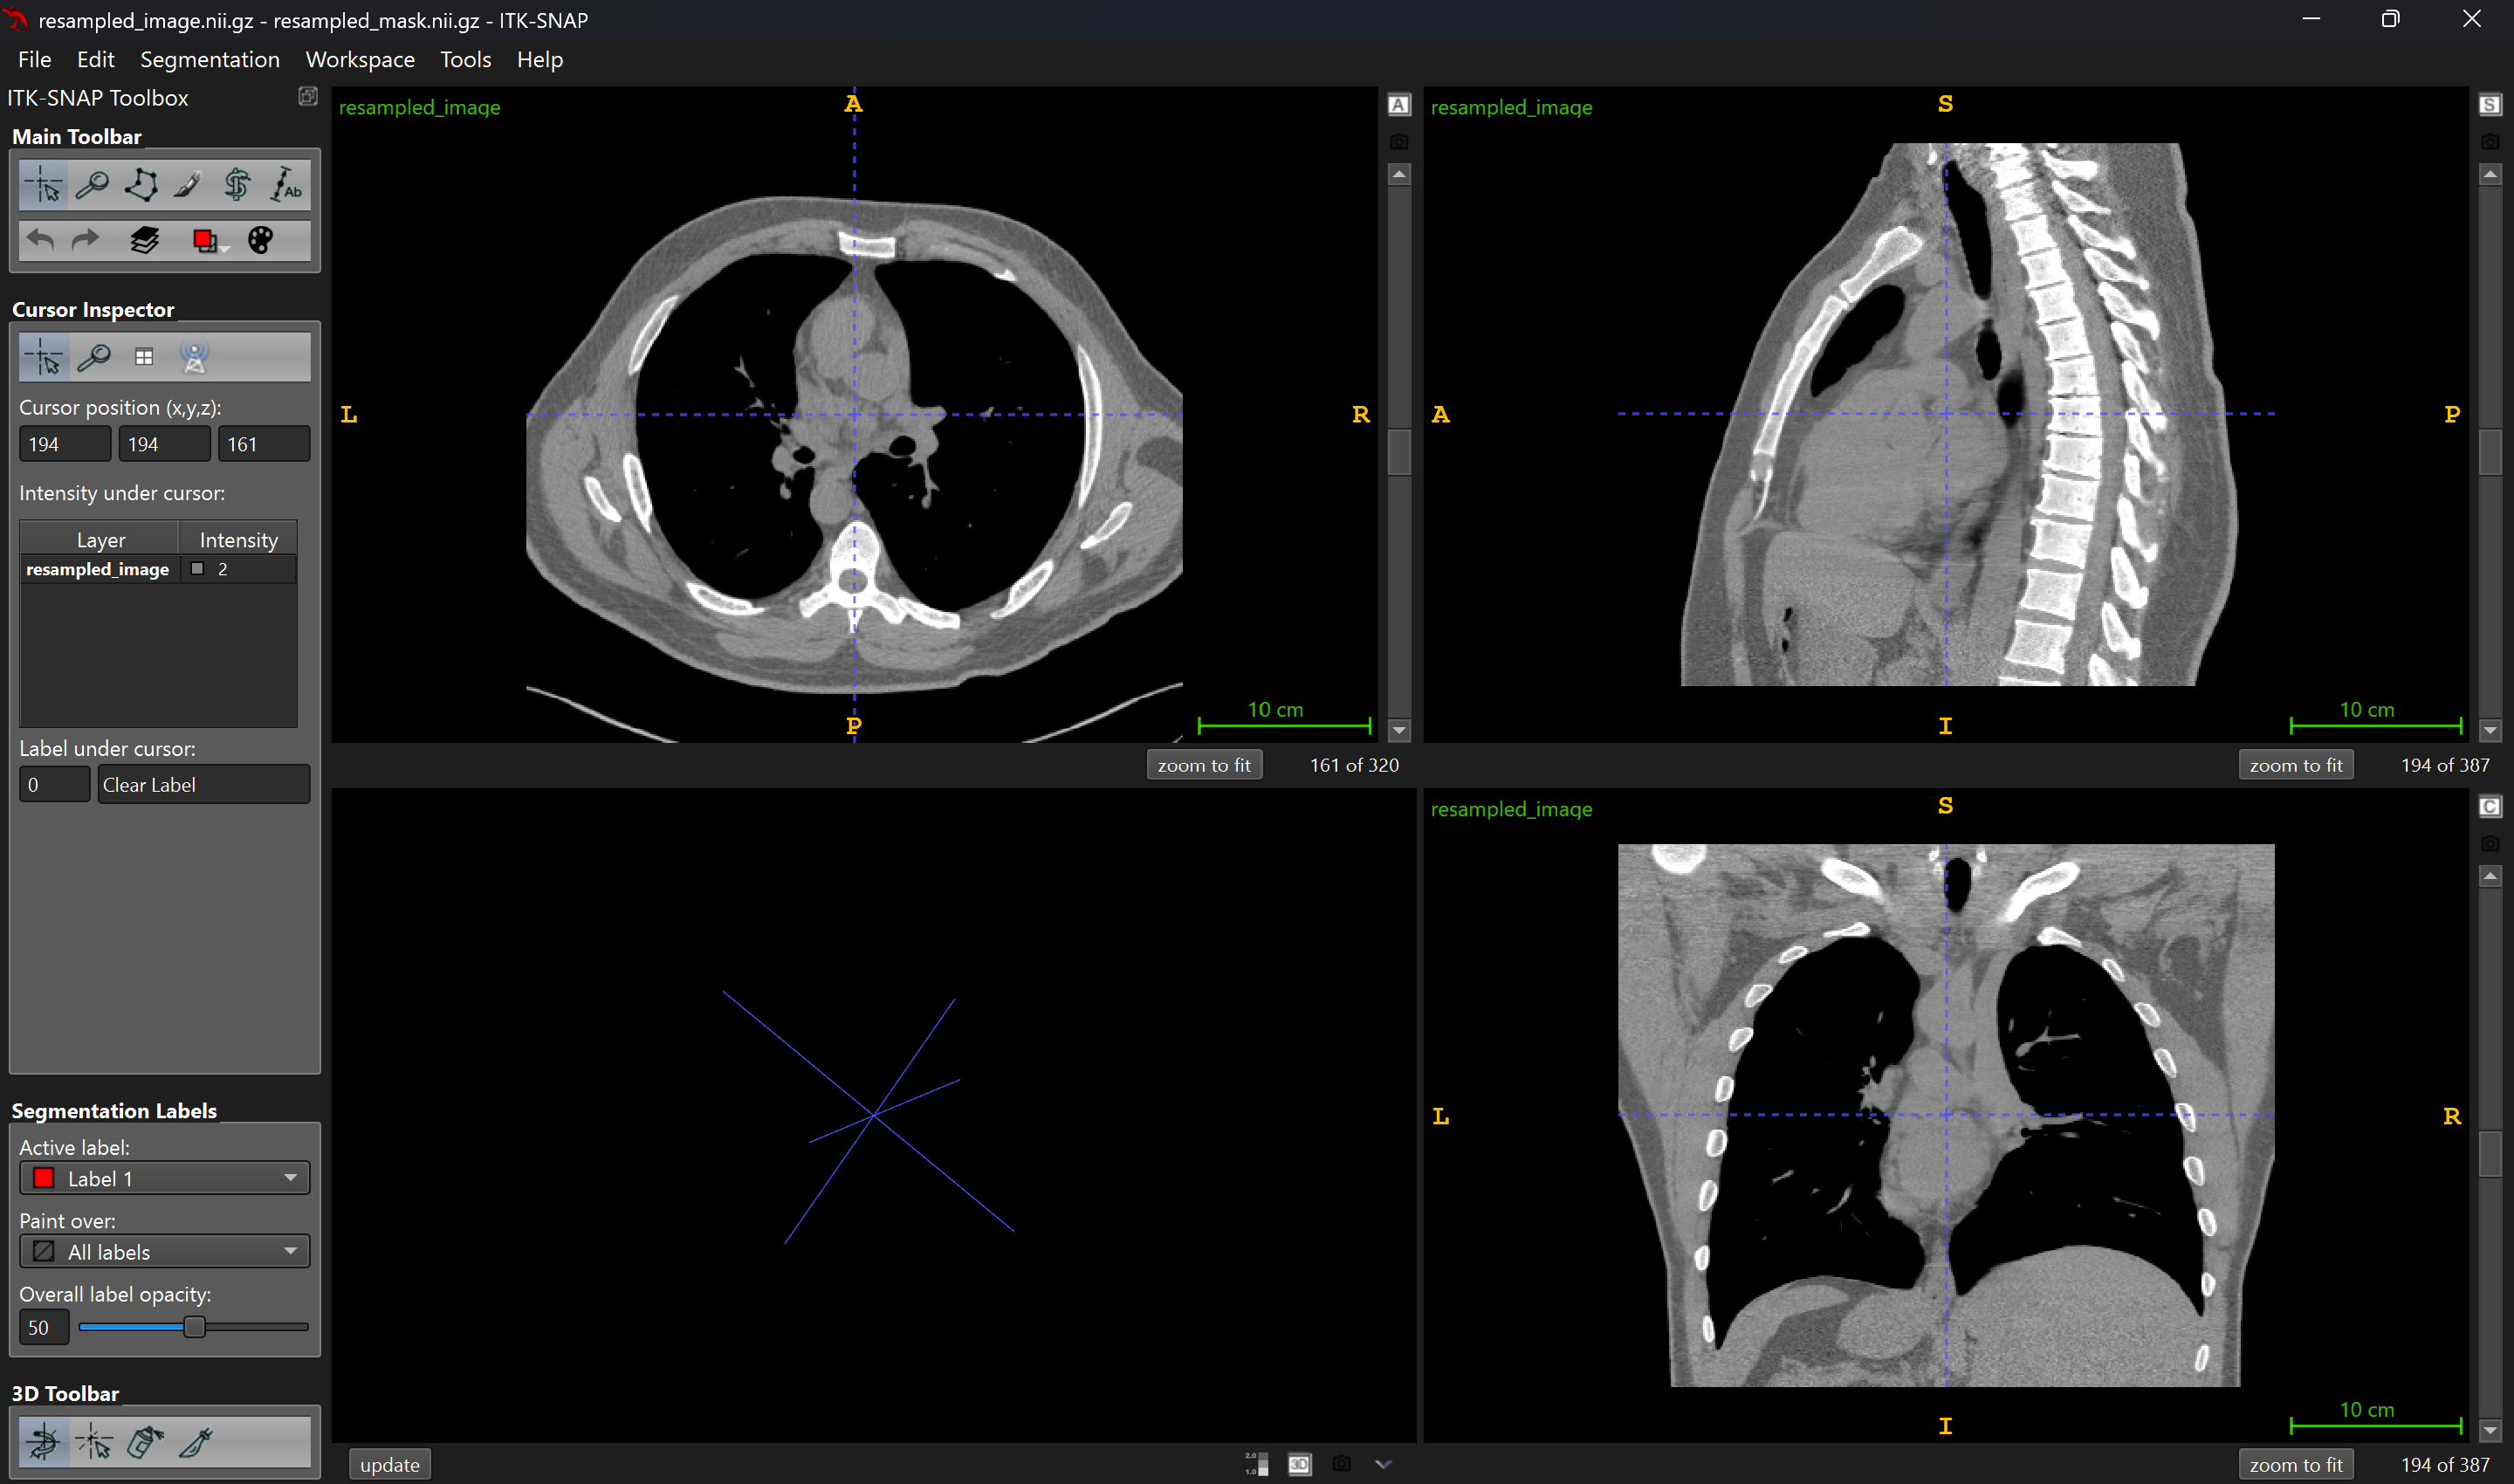**Answer:**